In [3]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms.v2 as transforms

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm

%matplotlib inline

In [4]:
from ray import tune
from ray.train import Checkpoint, get_checkpoint, report, RunConfig
from ray.tune.schedulers import ASHAScheduler

2024-10-20 21:03:34,810	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-20 21:03:35,891	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
# Function for loading dataset from 'pickle' file
def load_data(file):
    # Open 'pickle' file
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')
        """
        Data is a dictionary with four keys:
            'features' - is a 4D array with raw pixel data of the traffic sign images,
                         (number of examples, width, height, channels).
            'labels'   - is a 1D array containing the label id of the traffic sign image,
                         file label_names.csv contains id -> name mappings.
            'sizes'    - is a 2D array containing arrays (width, height),
                         representing the original width and height of the image.
            'coords'   - is a 2D array containing arrays (x1, y1, x2, y2),
                         representing coordinates of a bounding frame around the image.
        """
        # 4D numpy.ndarray type, for train = (34799, 32, 32, 3)
        input_data = d['features']
        # 1D numpy.ndarray type, for train = (34799,)
        target = d['labels']
        # 2D numpy.ndarray type, for train = (34799, 2)
        sizes = d['sizes']
        # 2D numpy.ndarray type, for train = (34799, 4)
        coords = d['coords']

    return input_data, target, sizes, coords

In [6]:
src_path = "C:\\Users\\pc\\Documents\\repos\\mp-2\\nn\\traffic_sign_cnn_hw\\"
train_path = src_path + "data\\train.pickle"
test_path = src_path + "data\\test.pickle"
valid_path = src_path + "data\\valid.pickle"
label_names_path = src_path + "data\label_names.csv"

In [7]:
X_train, y_train, *_ = load_data(train_path)
X_test, y_test, *_ = load_data(test_path)
X_valid, y_valid, *_ = load_data(valid_path)

In [8]:
label_names = pd.read_csv(label_names_path)

In [9]:
print("Training examples : ", len(X_train))
print("Validation examples : ", len(X_valid))
print("Testing examples : ", len(X_test))
print("Image data shape : ", X_train.shape)
print("Total classes : ", len(set(y_test)))

Training examples :  34799
Validation examples :  4410
Testing examples :  12630
Image data shape :  (34799, 32, 32, 3)
Total classes :  43


In [10]:
def draw_images_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array))
        image = image_array[index].squeeze()
        plt.axis('off')
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(image)

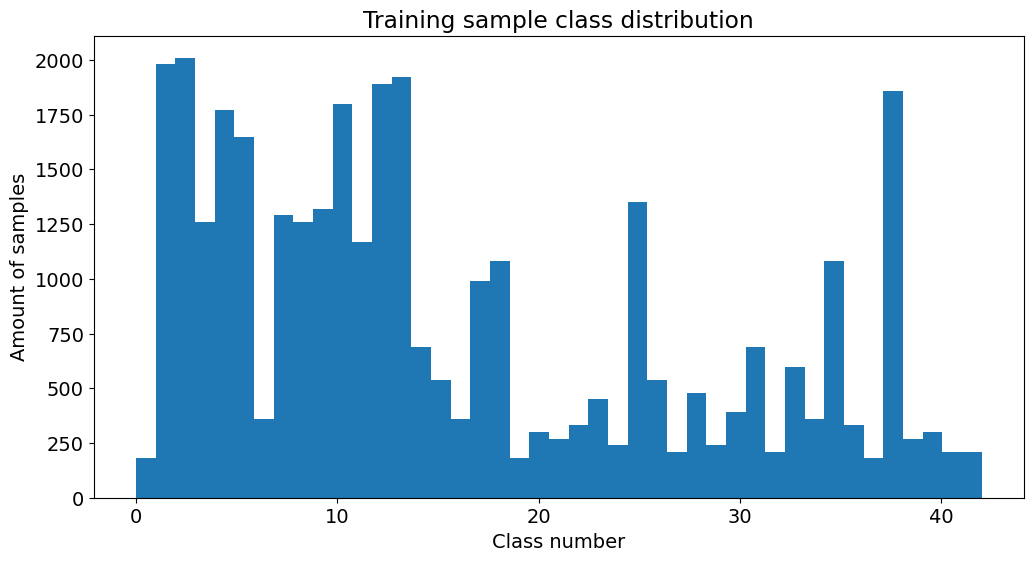

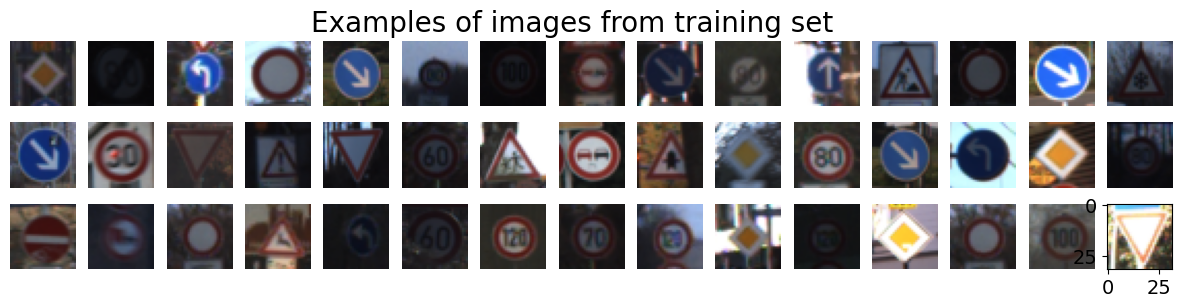

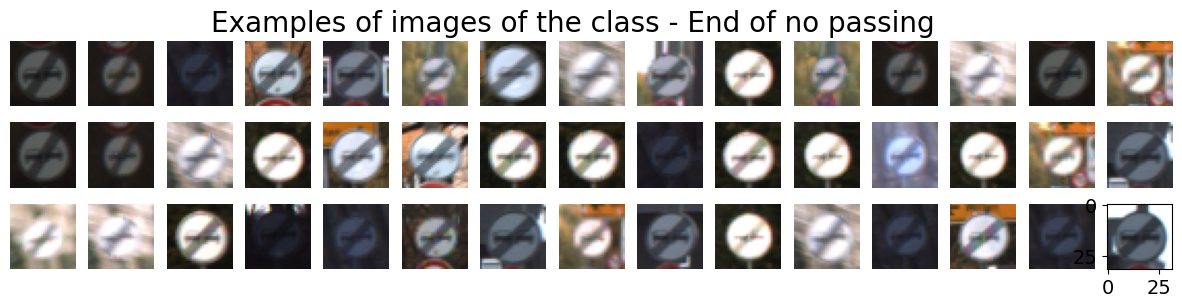

In [11]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(12,6))
n, bins, patches = plt.hist(y_train, len(set(y_train)))
plt.xlabel('Class number')
plt.ylabel('Amount of samples')
plt.title('Training sample class distribution')

draw_images_examples(X_train, 15, 3, 'Examples of images from training set')

example_class = y_train[random.randint(0, len(y_train))]

X_train_one_label = X_train[np.where(y_train==example_class)]
draw_images_examples(X_train_one_label, 15, 3, f'Examples of images of the class - {label_names["SignName"][example_class]}')

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

In [13]:
class TrafficSignDataset(Dataset):
    def __init__(self, path, transform=None):
        self.X, self.y, *_ = load_data(path)
        self.count = len(self.y)
        self.transform = transform

    def __getitem__(self, index):
        X = self.X[index]
        if self.transform is not None:
            X = self.transform(X)
        return X, self.y[index]

    def __len__(self):
        return self.count

In [14]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

In [15]:
class Model(nn.Module):
    def __init__(self, kernel_size: int, fc_1_out: int, fc_2_out: int):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size)
        self.conv2 = nn.Conv2d(6, 16, kernel_size)
        self.after_conv_size = int(((32 - kernel_size + 1) / 2 - kernel_size + 1) / 2)
        print(self.after_conv_size)
        self.fc1 = nn.Linear(16 * self.after_conv_size * self.after_conv_size, fc_1_out)
        self.fc2 = nn.Linear(fc_1_out, fc_2_out)
        self.fc3 = nn.Linear(fc_2_out, 43)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * self.after_conv_size * self.after_conv_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
def loss(model, loss_func, X, y, optimizer=None):
    loss_ = loss_func(model(X), y)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), len(X)

In [17]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X)

In [18]:
def fit(epochs, model, loss_func, optimizer, train_loader, valid_loader, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.Inf

    for epoch in tqdm(range(epochs)):

        model.train()

        losses = []
        for X, y  in train_loader:
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums = zip(*losses)
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accruacy: {valid_accuracy:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy))

            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses

    return graphic_losses

In [19]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums = zip(*validated_batches)
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100

    print(f"Test loss: {test_loss:.5f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")
    return test_loss, test_accuracy

In [20]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

In [21]:
import os

In [22]:
def train(config, constants):
    print(os.getcwd())
    model = Model(kernel_size=config["kernel_size"], fc_1_out=config["fc_1_out"], fc_2_out=config["fc_2_out"]).to(device)
    criterion = constants["criterion"]
    optimizer = optim.Adam(model.parameters(), lr=constants["lr"])
    n_epochs = constants["n_epochs"]
    transforms = constants["transforms"]
    saving_model_path = os.path.join(constants["saving_model_path"], 
                                "checkpoint_{kernel_size}_{fc_1_out}.model".format(kernel_size=config["kernel_size"], fc_1_out=config["fc_1_out"]))
    # if custom_train_path is not None:
    #     train_dataset = TrafficSignDataset(custom_train_path, transform=transforms)
    # else:
    train_dataset = TrafficSignDataset(train_path, transform=transforms)
    valid_dataset = TrafficSignDataset(valid_path, transform=transforms)
    test_dataset = TrafficSignDataset(test_path, transform=transforms)

    train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
    valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
    test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

    print('\nFitting nn model')
    start_time = time.time()

    losses_arr = fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
    print(f'Fit time: {time.time() - start_time} s')

    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    test_loss, test_accuracy = evaluate(model, criterion, test_loader)

    if saving_model_path is not None:
        print('Saving model')
        torch.save((model.state_dict(), optimizer.state_dict()), saving_model_path)
        checkpoint = Checkpoint.from_directory(constants["saving_model_path"])
        report(
            {"loss": test_loss, "accuracy": test_accuracy},
            checkpoint = checkpoint
        )

    # training_plots(losses_arr)

In [23]:
mean = (X_train / 256).mean((0, 1, 2))
std = (X_train / 256).std((0, 1, 2))

In [24]:
transforms_ = transforms.Compose([
    # transforms.ToImage(),
    # transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.2)),
    # transforms.RandomEqualize(),
    # transforms.ToDtype(dtype=torch.float32),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [1]:
config = {
    "fc_1_out": tune.grid_search([100, 200, 300, 400, 500]),
    "kernel_size": tune.grid_search([5]),
    "fc_2_out": tune.grid_search([500])
}

NameError: name 'tune' is not defined

In [26]:
constants = {"transforms": transforms_,
    "criterion": nn.CrossEntropyLoss(),
    "lr": 0.001,
    "n_epochs": 40,
    "saving_model_path": src_path + "models\\raytune"}

In [27]:
def train_model(num_samples=3, gpus_per_trial=0.125):
    # scheduler = ASHAScheduler(
    #     max_t=max_num_epochs,
    #     grace_period=1,
    #     reduction_factor=2)
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train, constants=constants),
            resources={"cpu": 0.25, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="accuracy",
            mode="max",
            # scheduler=scheduler,
            num_samples=num_samples,
            # search_alg=ax_search
        ),
        param_space=config,
        run_config=RunConfig(storage_path=os.path.join(src_path, "raytune"))
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("accuracy", "max")

    return best_result

In [1]:
best = train_model()

NameError: name 'train_model' is not defined

Results and conclusions

1) Choosing preprocessing steps
I checked the following steps and combinations:

    The results are from running "default" model.
    The best results were achieved for Normalize function (Also combination of RandomResizedCrop and Normalize achieved promising results with lower learing rate, higher patience).

2) Running grid search for hyper-parameters (
    kernel size for CNN - "kernel_size", 
    size of the first fully connected layer - "fc_1_out"
    ). 
    I ran 3 runs for each configuration from the scope:

    "fc_1_out": tune.grid_search([100, 200, 300, 400, 500]),
    "kernel_size": tune.grid_search([3, 5])
    Size of second fully connected layer is constant - 84.
    
    Results (best for each combination):
    ![alt text](image.png)
    The best values are:
    kernel_size = 5
    fc_1_out = 400
    Accuracy = 93.11%

3) Running grid search for hyper-parameters (
    size of the first fully connected layer - "fc_1_out",
    size of the second fully connected layer - "fc_2_out"
)
    I ran 1 run for each configuration from the scope:

    "fc_1_out": tune.grid_search([100, 200, 300, 400, 500]),
    "fc_2_out": tune.grid_search([100, 200, 300, 400, 500])
    Kernel size is constant - 5.

    Results:
    ![alt text](image-1.png)
    The best values are:
    fc_1_out = 400
    fc_2_out = 300
    Accuracy = 93.71%

Conclusions

Kernel size 5 is definetely better then 3 (as seen in first results).
Higher values for fc_1_out, fc_2_out have better accuracy.
Also, second wave of experiments ran only once for each hyperparameter combination, and we can see enough deviation in first wave results to conclude uncertainty regarding exact best values for fc_1_out, fc_2_out.